# Final Project Notebook 8 - Word Embedding 2

## Metadata

```

MacKenzye Leroy (zuf9mc@vriginia.edu)
DS 5001
2 May 2022

Purpose:  This notebook cuses word2vec on each individual author
Note: Much of the code in the notebook was originally witten by Dr. Rafael Alverado and has been editted to fit my particular problem 
```

# Set Up

In [1]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from sklearn.manifold import TSNE
from scipy.linalg import norm


In [2]:
import plotly.express as px
import seaborn as sns; sns.set()
import os

In [3]:
norm_docs = True # L2 norming
center_by_mean = True 
n_terms = 1000 # Number of significant words; feature space
k = 6 # Number of components

In [4]:
#os.chdir('/Users/mackenzyeleroy/Documents/MSDS/DS5001/FinalProject')
home_dir = os.getcwd()
home_dir

'/Users/mackenzyeleroy/Documents/MSDS/DS5001/ETA-Final-Project/FinalProject'

In [5]:
data_home = f"{home_dir}/Data"
parser_lib = f"{home_dir}/lib"
source_files = f'{data_home}/output'
data_prefix = 'wells-verne'

In [6]:
OHCO = ['book_id','chap_id','para_num','sent_num','token_num']

In [7]:
Wells_w2v_params = dict(
    min_count = 50,
    #workers = 4,
    vector_size = 256,
    window = 2    
)

In [8]:
Verne_w2v_params = dict(
    min_count = 50,
    #workers = 4,
    vector_size = 256,
    window = 2    
)

In [9]:
tsne_params = dict(
    learning_rate = 200., #'auto' or [10.0, 1000.0]
    perplexity = 20,
    n_components = 2,
    init = 'random',
    n_iter = 1000,
    random_state = 42    
)

# Get Data

In [10]:
TOKENS = pd.read_csv(f"{source_files}/{data_prefix}-CORPUS.csv").set_index(OHCO)

In [11]:
TOKENS.head()

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                                
35      1       0        0        0          ('Introduction', 'NN')   NN   
                1        0        0                   ('The', 'DT')   DT   
                                  1                 ('Time', 'NNP')  NNP   
                                  2            ('Traveller', 'NNP')  NNP   
                                  3                 ('(for', 'NNP')  NNP   

                                                token_str      term_str  
book_id chap_id para_num sent_num token_num                              
35      1       0        0        0          Introduction  introduction  
                1        0        0                   The           the  
                                  1                  Time          time  
                                  2             Traveller     traveller  
                                  3                  (for           for

In [12]:
#need to seperate our CORPUS by auther ussing Gutenburg id numbers
WellsCORPUSNum = [780, 718, 6424, 5230, 36, 35, 159, 12163, 1059, 1013]
VerneCORPUSNum = [44278, 3526, 3091, 18857, 16457, 164, 1355, 1353, 1268, 103]

In [13]:
TOKENS = TOKENS.reset_index()
WellsTOKENS = TOKENS[TOKENS.book_id.isin(WellsCORPUSNum)]
VerneTOKENS = TOKENS[TOKENS.book_id.isin(VerneCORPUSNum)]
WellsTOKENS = WellsTOKENS.set_index(OHCO)
VerneTOKENS = VerneTOKENS.set_index(OHCO)
TOKENS = TOKENS.set_index(OHCO)
WellsTOKENS

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                                
35      1       0        0        0          ('Introduction', 'NN')   NN   
                1        0        0                   ('The', 'DT')   DT   
                                  1                 ('Time', 'NNP')  NNP   
                                  2            ('Traveller', 'NNP')  NNP   
                                  3                 ('(for', 'NNP')  NNP   
...                                                             ...  ...   
12163   25      45       0        14                 ('was', 'VBD')  VBD   
                                  15                 ('very', 'RB')   RB   
                                  16                ('near.', 'JJ')   JJ   
                46       0        0                   ('THE', 'DT')   DT   
                                  1                 ('END.', 'NNP')  NNP   

                                                token_str      term_str  
book_id chap_id para_num sent_num token_num                              
35      1       0        0        0          Introduction  introduction  
                1        0        0                   The           the  
                                  1                  Time          time  
                                  2             Traveller     traveller  
                                  3                  (for           for  
...                                                   ...           ...  
12163   25      45       0        14                  was           was  
                                  15                 very          very  
                                  16                near.          near  
                46       0        0                   THE           the  
                                  1                  END.           end  

[861960 rows x 4 columns]

In [14]:
VerneTOKENS 

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                            
103     1       0        0        0               ('IN', 'NNP')  NNP   
                                  1            ('WHICH', 'NNP')  NNP   
                                  2          ('PHILEAS', 'NNP')  NNP   
                                  3             ('FOGG', 'NNP')  NNP   
                                  4              ('AND', 'NNP')  NNP   
...                                                         ...  ...   
44278   28      15       1        14             ('will', 'MD')   MD   
                                  15             ('come', 'VB')   VB   
                                  16              ('out', 'RP')   RP   
                                  17              ('all', 'DT')   DT   
                                  18          ('right."', 'NN')   NN   

                                            token_str term_str  
book_id chap_id para_num sent_num token_num                     
103     1       0        0        0                IN       in  
                                  1             WHICH    which  
                                  2           PHILEAS  phileas  
                                  3              FOGG     fogg  
                                  4               AND      and  
...                                               ...      ...  
44278   28      15       1        14             will     will  
                                  15             come     come  
                                  16              out      out  
                                  17              all      all  
                                  18          right."    right  

[914683 rows x 4 columns]

In [15]:
len(TOKENS) == len(WellsTOKENS) + len(VerneTOKENS)

True

# Extract VOCAB

Use this to filter significant terms and to store w2v features and tSNE coordinates.

In [16]:
WellsVOCAB = WellsTOKENS.term_str.value_counts().to_frame('n')
WellsVOCAB.index.name = 'term_str'

In [17]:
WellsVOCAB['pos_max'] = WellsTOKENS.value_counts(['term_str','pos']).unstack().idxmax(1)

In [18]:
WellsVOCAB['pos_group'] = WellsVOCAB.pos_max.str.slice(0,2)

## Mel

In [19]:
VerneVOCAB = VerneTOKENS.term_str.value_counts().to_frame('n')
VerneVOCAB.index.name = 'term_str'

In [20]:
VerneVOCAB['pos_max'] = VerneTOKENS.value_counts(['term_str','pos']).unstack().idxmax(1)

In [21]:
VerneVOCAB['pos_group'] = VerneVOCAB.pos_max.str.slice(0,2)

# Add Chapter Significance

In [22]:
WellsCHAPS = WellsTOKENS.groupby(OHCO[:2]+['term_str']).term_str.count()\
    .unstack(fill_value=0).astype('bool').astype('int')

In [23]:
WellsCHAPS.head()

term_str         1  10  1000  10000000  101  105  107  11  12  140000000  ...  \
book_id chap_id                                                           ...   
35      1        0   0     0         0    0    0    0   0   0          0  ...   
        2        0   0     0         0    0    0    0   0   0          0  ...   
        3        0   0     0         0    0    0    0   0   0          0  ...   
        4        0   0     0         0    0    0    0   0   0          0  ...   
        5        0   0     0         0    0    0    0   0   0          0  ...   

term_str         à  â  âtrice  æsthetic  æstheticism  éclat  épicier  ō  α  β  
book_id chap_id                                                                
35      1        0  0       0         0            0      0        0  0  0  0  
        2        0  0       0         0            0      0        0  0  0  0  
        3        0  0       0         0            0      0        0  0  0  0  
        4        0  0       0         0            0      0        0  0  0  0  
        5        0  0       0         0            0      0        0  0  0  0  

[5 rows x 28510 columns]

In [24]:
WellsVOCAB['df'] = WellsCHAPS.sum()
WellsVOCAB['dfidf'] = WellsVOCAB.df * np.log2(len(WellsCHAPS)/WellsVOCAB.df)

In [25]:
WellsVOCAB.sort_values('dfidf', ascending=False)

n pos_max pos_group   df     dfidf
term_str                                        
flung       109      NN        NN   69  99.24753
does        269     VBZ        VB   69  99.24753
talk        273      VB        VB   69  99.24753
started     110     VBD        VB   69  99.24753
hot         121      JJ        JJ   69  99.24753
...         ...     ...       ...  ...       ...
in        14522      IN        IN  187   0.00000
to        19581      TO        TO  187   0.00000
a         22780      DT        DT  187   0.00000
of        32821      IN        IN  187   0.00000
the       53614      DT        DT  187   0.00000

[28510 rows x 5 columns]

## Verne

In [26]:
VerneCHAPS = VerneTOKENS.groupby(OHCO[:2]+['term_str']).term_str.count()\
    .unstack(fill_value=0).astype('bool').astype('int')

In [27]:
VerneCHAPS.head()

term_str         0  000436  016  05  092  0h  1  10  100  1000  ...  \
book_id chap_id                                                 ...   
103     1        0       0    0   0    0   0  0   0    0     0  ...   
        2        0       0    0   0    0   0  0   0    0     0  ...   
        3        0       0    0   0    0   0  0   0    0     0  ...   
        4        0       0    0   0    0   0  0   0    0     0  ...   
        5        0       0    0   0    0   0  0   0    0     0  ...   

term_str         zoroasterthe  zostera  zouave  zouricolo  zqq  zulma  \
book_id chap_id                                                         
103     1                   0        0       0          0    0      0   
        2                   0        0       0          0    0      0   
        3                   0        0       0          0    0      0   
        4                   0        0       0          0    0      0   
        5                   0        0       0          0    0      0   

term_str         zungomoro  zvdk  à  œdipus  
book_id chap_id                              
103     1                0     0  0       0  
        2                0     0  0       0  
        3                0     0  0       0  
        4                0     0  0       0  
        5                0     0  0       0  

[5 rows x 26359 columns]

In [28]:
VerneVOCAB['df'] = VerneCHAPS.sum()
VerneVOCAB['dfidf'] = VerneVOCAB.df * np.log2(len(VerneCHAPS)/VerneVOCAB.df)

In [29]:
VerneVOCAB.sort_values('dfidf', ascending=False)

n pos_max pos_group   df       dfidf
term_str                                          
reason      219      NN        NN  142  205.394854
south       275      NN        NN  142  205.394854
below       231      IN        IN  142  205.394854
got         217     VBD        VB  143  205.393534
things      197     NNS        NN  143  205.393534
...         ...     ...       ...  ...         ...
and       23300      CC        CC  387    0.000000
of        34550      IN        IN  387    0.000000
in        14483      IN        IN  387    0.000000
at         6626      IN        IN  387    0.000000
the       72801      DT        DT  387    0.000000

[26359 rows x 5 columns]

# Get List of Token Lists

For Gensim

In [30]:
WellsSENTS = WellsTOKENS.groupby(OHCO[:-1]).term_str.apply(lambda  x:  x.tolist())

In [31]:
VerneSENTS = VerneTOKENS.groupby(OHCO[:-1]).term_str.apply(lambda  x:  x.tolist())

# Learn Word Embeddings

In [32]:
WellsSENTS.head().tolist()

[['introduction'],
 ['the',
  'time',
  'traveller',
  'for',
  'so',
  'it',
  'will',
  'be',
  'convenient',
  'to',
  'speak',
  'of',
  'him',
  'was',
  'expounding',
  'a',
  'recondite',
  'matter',
  'to',
  'us'],
 ['his',
  'pale',
  'grey',
  'eyes',
  'shone',
  'and',
  'twinkled',
  'and',
  'his',
  'usually',
  'pale',
  'face',
  'was',
  'flushed',
  'and',
  'animated'],
 ['the',
  'fire',
  'burnt',
  'brightly',
  'and',
  'the',
  'soft',
  'radiance',
  'of',
  'the',
  'incandescent',
  'lights',
  'in',
  'the',
  'lilies',
  'of',
  'silver',
  'caught',
  'the',
  'bubbles',
  'that',
  'flashed',
  'and',
  'passed',
  'in',
  'our',
  'glasses'],
 ['our',
  'chairs',
  'being',
  'his',
  'patents',
  'embraced',
  'and',
  'caressed',
  'us',
  'rather',
  'than',
  'submitted',
  'to',
  'be',
  'sat',
  'upon',
  'and',
  'there',
  'was',
  'that',
  'luxurious',
  'after',
  'dinner',
  'atmosphere',
  'when',
  'thought',
  'runs',
  'gracefully',
  

In [33]:
VerneSENTS.head().tolist()

[['in',
  'which',
  'phileas',
  'fogg',
  'and',
  'passepartout',
  'accept',
  'each',
  'other',
  'the',
  'one',
  'as',
  'master',
  'the',
  'other',
  'as',
  'man'],
 ['mr', 'phileas', 'fogg', 'lived', 'in', '1872', 'at', 'no'],
 ['7',
  'saville',
  'row',
  'burlington',
  'gardens',
  'the',
  'house',
  'in',
  'which',
  'sheridan',
  'died',
  'in',
  '1814'],
 ['he',
  'was',
  'one',
  'of',
  'the',
  'most',
  'noticeable',
  'members',
  'of',
  'the',
  'reform',
  'club',
  'though',
  'he',
  'seemed',
  'always',
  'to',
  'avoid',
  'attracting',
  'attention',
  'an',
  'enigmatical',
  'personage',
  'about',
  'whom',
  'little',
  'was',
  'known',
  'except',
  'that',
  'he',
  'was',
  'a',
  'polished',
  'man',
  'of',
  'the',
  'world'],
 ['people',
  'said',
  'that',
  'he',
  'resembled',
  'byronat',
  'least',
  'that',
  'his',
  'head',
  'was',
  'byronic',
  'but',
  'he',
  'was',
  'a',
  'bearded',
  'tranquil',
  'byron',
  'who',
  '

Fit individual models

In [34]:
WellsModel = word2vec.Word2Vec(WellsSENTS.values, **Wells_w2v_params)
VerneModel = word2vec.Word2Vec(VerneSENTS.values, **Verne_w2v_params)

### Wells

In [35]:
WellsW2V = pd.DataFrame(WellsModel .wv.get_normed_vectors(), index=WellsModel .wv.index_to_key)
WellsW2V.index.name = 'term_str'
WellsW2V = WellsW2V.sort_index()

In [36]:
WellsW2V.head()

0         1         2         3         4         5    \
term_str                                                               
a         0.036310 -0.037154  0.057445 -0.074898  0.025618 -0.050659   
able     -0.070469 -0.011084 -0.012226 -0.045381  0.153292  0.057165   
about     0.127755 -0.100510 -0.046997 -0.004547  0.035636  0.016550   
above     0.056435 -0.038466 -0.019411  0.075082 -0.051943  0.017511   
abruptly -0.114771 -0.016190 -0.025796 -0.009660 -0.015207 -0.051473   

               6         7         8         9    ...       246       247  \
term_str                                          ...                       
a         0.009891  0.044460 -0.044739 -0.085194  ...  0.003364 -0.008117   
able      0.115761 -0.044978 -0.004384  0.076066  ...  0.028165 -0.012313   
about     0.027389 -0.104906 -0.059370  0.037235  ...  0.026160  0.028470   
above     0.078118  0.014175 -0.014572  0.034377  ...  0.036626  0.010598   
abruptly  0.051930 -0.105213 -0.031905  0.073932  ... -0.035876  0.045155   

               248       249       250       251       252       253  \
term_str                                                               
a        -0.065699  0.027858 -0.051895 -0.081407 -0.029193  0.042777   
able     -0.064988  0.023426 -0.019782 -0.074092  0.151064  0.054089   
about    -0.010031 -0.035509 -0.010001 -0.040925 -0.072757  0.018967   
above    -0.050630 -0.052340 -0.048939  0.014457 -0.078491 -0.070613   
abruptly -0.124678 -0.096751  0.022845  0.028847 -0.061775  0.121161   

               254       255  
term_str                      
a         0.080927 -0.072546  
able      0.001435  0.041373  
about     0.058677  0.038868  
above    -0.109167  0.064781  
abruptly -0.053388  0.008640  

[5 rows x 256 columns]

## Verne

In [37]:
VerneW2V = pd.DataFrame(VerneModel .wv.get_normed_vectors(), index=VerneModel .wv.index_to_key)
VerneW2V.index.name = 'term_str'
VerneW2V = VerneW2V.sort_index()

In [38]:
VerneW2V.head()

0         1         2         3         4         5    \
term_str                                                               
1         0.062974 -0.078991  0.003520  0.049158  0.061812  0.063106   
2         0.068392 -0.066684 -0.017048  0.032338  0.062574  0.090418   
20th      0.039584 -0.031858 -0.016830  0.029147  0.053841 -0.039939   
3         0.084624 -0.059766 -0.013391  0.030770  0.058093  0.089293   
4         0.083300 -0.065174 -0.028519  0.022621  0.055494  0.092746   

               6         7         8         9    ...       246       247  \
term_str                                          ...                       
1         0.065682  0.052737  0.023039  0.040204  ...  0.070565  0.029761   
2         0.048008  0.018806  0.008616  0.019104  ...  0.048481  0.062606   
20th      0.123467  0.092250 -0.029881 -0.013855  ...  0.020618 -0.054965   
3         0.038749  0.031088  0.031060  0.030511  ...  0.041752  0.050076   
4         0.036442  0.016452  0.007794  0.008573  ...  0.038432  0.055186   

               248       249       250       251       252       253  \
term_str                                                               
1        -0.132999  0.007097 -0.087070  0.067283 -0.056602 -0.046262   
2        -0.131766 -0.013420 -0.069583  0.054529 -0.061920  0.006820   
20th     -0.088635  0.085133 -0.087903 -0.005138 -0.014126 -0.055111   
3        -0.134544 -0.002479 -0.069948  0.057067 -0.046016 -0.017446   
4        -0.125110  0.001180 -0.081620  0.045396 -0.070901  0.011409   

               254       255  
term_str                      
1        -0.092610 -0.028096  
2        -0.061824 -0.010868  
20th     -0.149749 -0.069988  
3        -0.056912 -0.028150  
4        -0.082437 -0.028714  

[5 rows x 256 columns]

# Visualize with tSNE

In [39]:
tsne_engine = TSNE(**tsne_params)
Wells_tsne_model = tsne_engine.fit_transform(WellsW2V)

In [40]:
WellsCOORDS = pd.DataFrame(Wells_tsne_model, columns=['x','y'], index=WellsW2V.index)\
    .join(WellsVOCAB, how='left')[['x','y','n','dfidf','pos_group']]

In [41]:
WellsCOORDS = WellsCOORDS[WellsCOORDS.dfidf.notnull()]

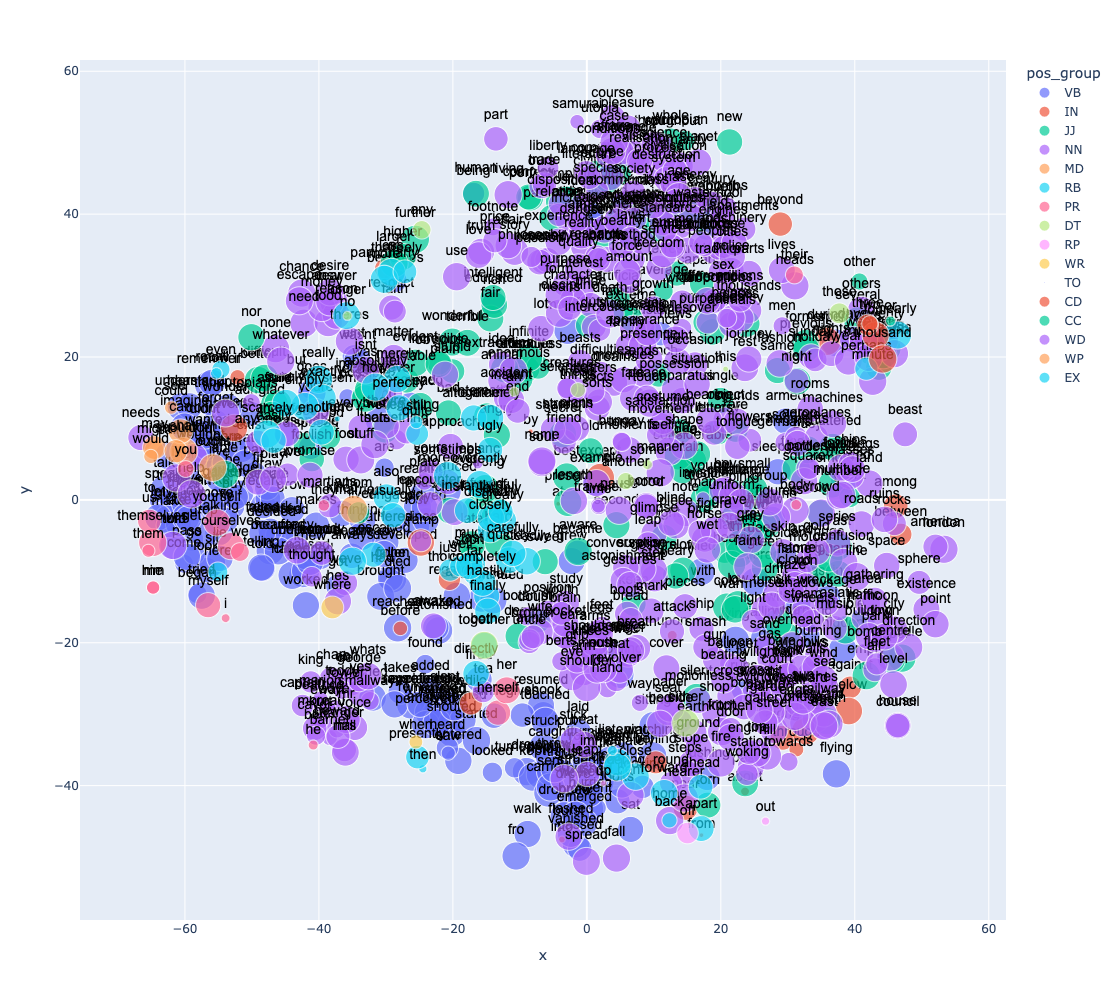

In [42]:
px.scatter(WellsCOORDS.reset_index().sample(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='dfidf',           
           height=1000, width=1200).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

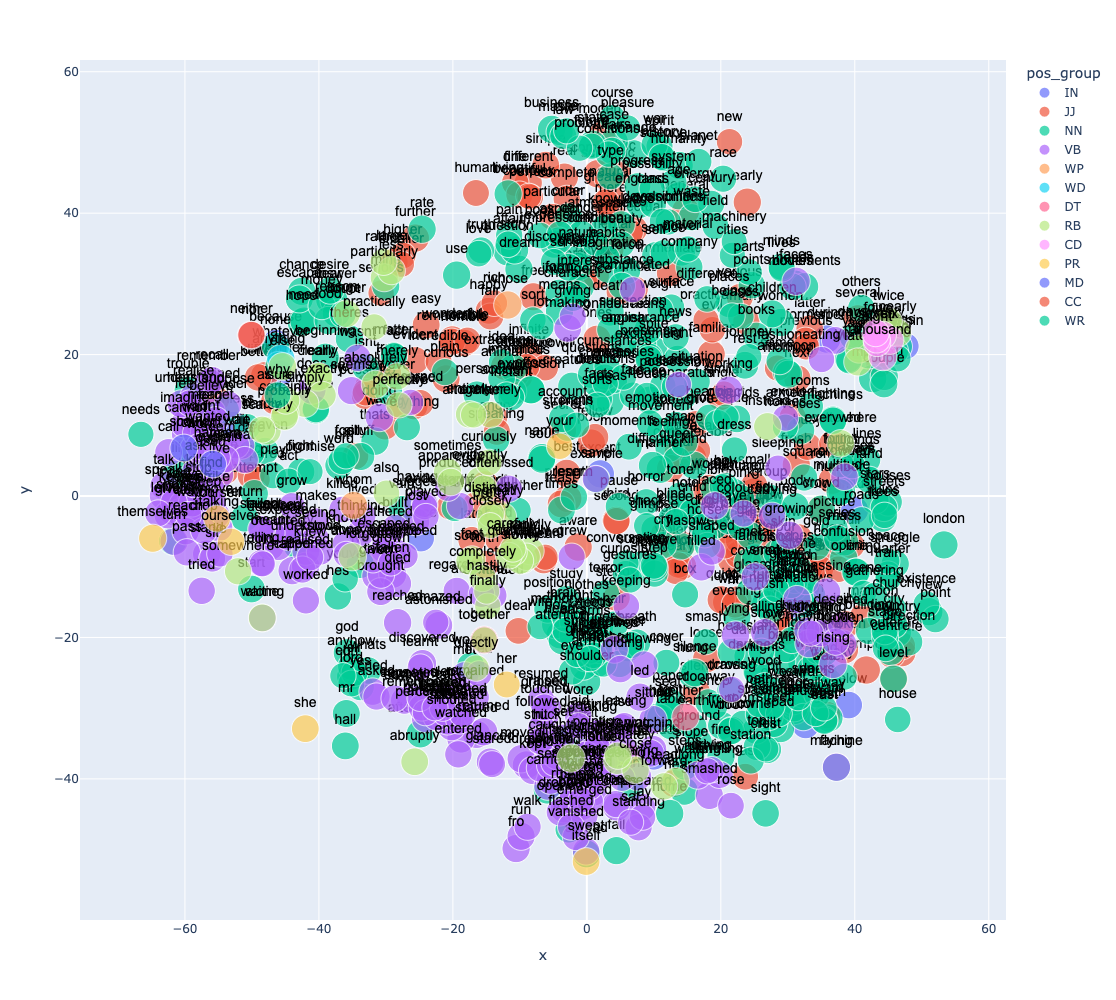

In [43]:
px.scatter(WellsCOORDS.reset_index().sort_values('dfidf', ascending=False).head(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='dfidf',           
           height=1000, width=1200).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

In [44]:
tsne_engine = TSNE(**tsne_params)
Verne_tsne_model = tsne_engine.fit_transform(VerneW2V)

In [45]:
VerneCOORDS = pd.DataFrame(Verne_tsne_model, columns=['x','y'], index=VerneW2V.index)\
    .join(VerneVOCAB, how='left')[['x','y','n','dfidf','pos_group']]

In [46]:
VerneCOORDS = VerneCOORDS[VerneCOORDS.dfidf.notnull()]

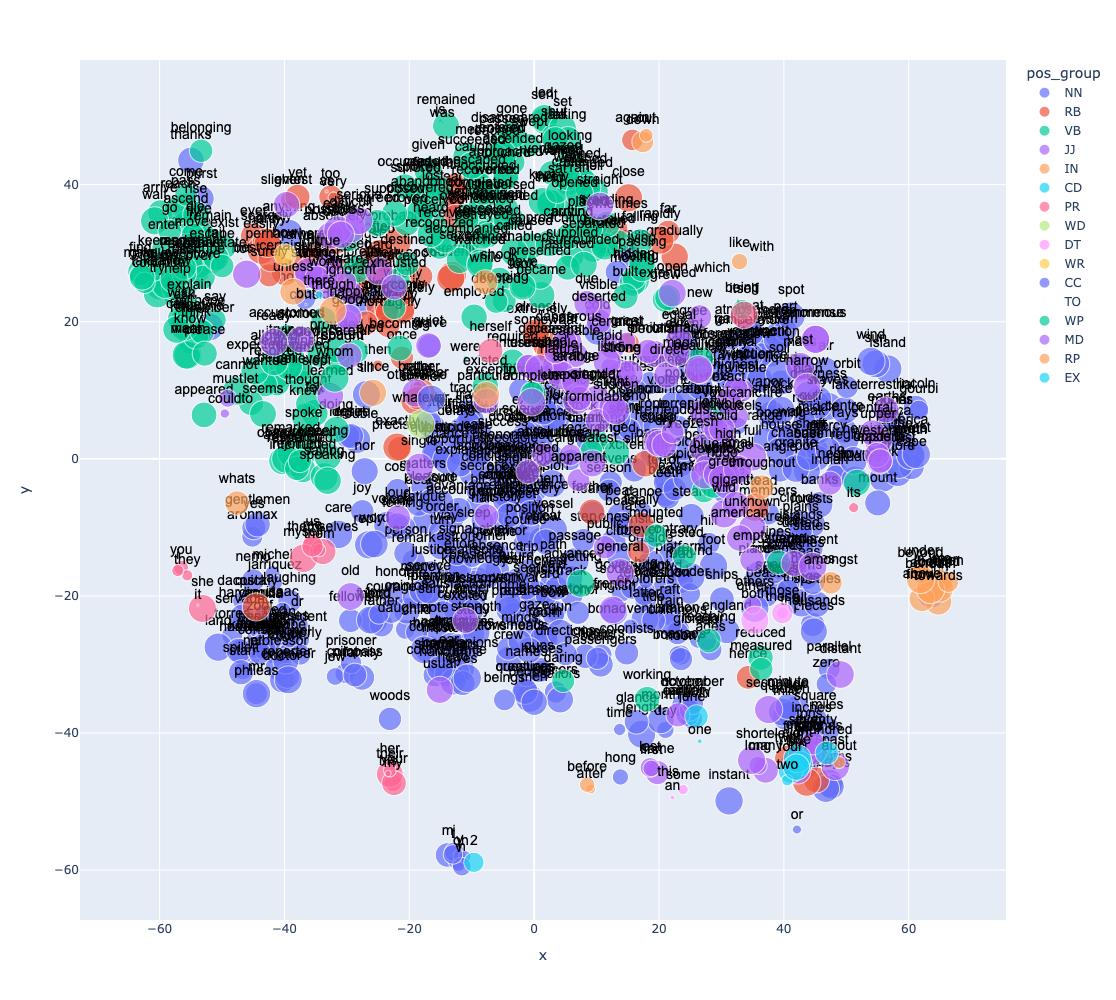

In [47]:
px.scatter(VerneCOORDS.reset_index().sample(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='dfidf',           
           height=1000, width=1200).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

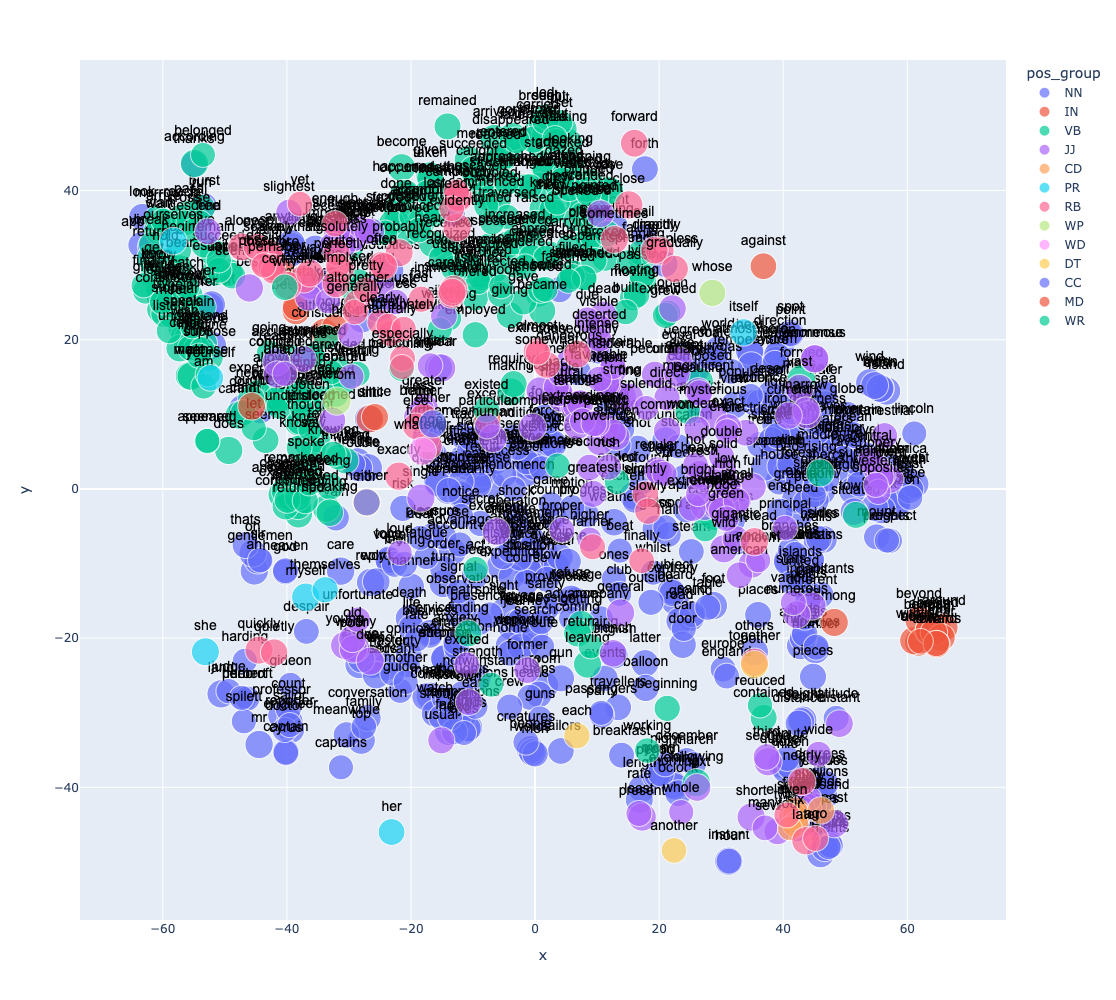

In [48]:
px.scatter(VerneCOORDS.reset_index().sort_values('dfidf', ascending=False).head(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='dfidf',           
           height=1000, width=1200).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

# Semantic Algebra

## Analogies

$A : B :: C : D? \rightarrow B - A + C = D$


In [49]:
def complete_analogy_Wells(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(WellsModel.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar_Wells(positive, negative=None):
    return pd.DataFrame(WellsModel.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [50]:
def complete_analogy_Verne(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(VerneModel.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar_Verne(positive, negative=None):
    return pd.DataFrame(VerneModel.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [51]:
complete_analogy_Verne('earth', 'moon', 'father', 3)

term       sim
0   master  0.836318
1   friend  0.826426
2  friends  0.806589

In [52]:
complete_analogy_Wells('earth', 'moon', 'father', 3)

term       sim
0  terror  0.719063
1   cabin  0.701799
2  uncles  0.700539

In [53]:
get_most_similar_Wells('moon')

term       sim
0   valley  0.717648
1    earth  0.686706
2  surface  0.673127
3    lunar  0.671281
4      sea  0.661510
5     park  0.657852
6    stage  0.640778
7   fabric  0.640243
8   empire  0.638528
9    outer  0.631658

In [54]:
get_most_similar_Verne('moon')

term       sim
0       earth  0.870543
1         sun  0.828638
2  projectile  0.806443
3      island  0.744658
4      gallia  0.735980
5     balloon  0.735298
6       coast  0.735209
7    nautilus  0.728779
8        wind  0.722798
9        brig  0.716703

In [55]:
get_most_similar_Verne('excitement')

term       sim
0        terror  0.895612
1      profound  0.890831
2       machine  0.880980
3       lantern  0.878839
4     frightful  0.873108
5      watching  0.869635
6          step  0.869011
7  astonishment  0.861743
8         steel  0.860629
9       silence  0.854595

In [56]:
get_most_similar_Wells('excitement')

term       sim
0      presence  0.888674
1       popular  0.868299
2    suggestion  0.832543
3    conception  0.817123
4      conflict  0.816965
5       comfort  0.815457
6  astonishment  0.808438
7      standard  0.806513
8     grotesque  0.806481
9          ends  0.802633

In [57]:
get_most_similar_Wells('earth')

term       sim
0     moon  0.686706
1       on  0.623355
2   either  0.590158
3     goes  0.582027
4  surface  0.561832
5    beach  0.547102
6  america  0.546061
7   ground  0.527359
8     runs  0.523407
9       go  0.517410

In [58]:
get_most_similar_Verne('earth')

term       sim
0        moon  0.870543
1         sun  0.836421
2       coast  0.810420
3     surface  0.786795
4    interior  0.783917
5       lunar  0.771681
6  atmosphere  0.757835
7       globe  0.756862
8  projectile  0.754346
9      centre  0.753128

In [59]:
get_most_similar_Verne('island')

term       sim
0       earth  0.746373
1        moon  0.744658
2       coast  0.717012
3  atmosphere  0.714470
4     lincoln  0.691365
5     unknown  0.691194
6       point  0.669284
7       islet  0.667307
8      gallia  0.651355
9       orbit  0.643126

In [60]:
get_most_similar_Wells('island')

term       sim
0         roof  0.757156
1          gas  0.745683
2         sand  0.739576
3    gathering  0.738147
4        grass  0.734666
5  realisation  0.733304
6         yard  0.732068
7         rush  0.731011
8       centre  0.730181
9       office  0.728647

In [61]:
get_most_similar_Wells('journey')

term       sim
0    immediate  0.767323
1    necessity  0.756646
2     previous  0.747717
3  terrestrial  0.745162
4     strength  0.739988
5       nights  0.729078
6       empire  0.724710
7       secret  0.724439
8    adventure  0.724306
9       former  0.723012

In [62]:
get_most_similar_Verne('journey')

term       sim
0       trip  0.856428
1     voyage  0.854120
2     search  0.832382
3     prison  0.829049
4    arrival  0.827976
5  departure  0.818621
6     flight  0.811029
7       yard  0.805276
8      route  0.803483
9  satellite  0.803078

# Save

In [63]:
WellsW2V.to_csv(f'{data_home}/output/WELLS-W2V.csv')
VerneW2V.to_csv(f'{data_home}/output/VERNE-W2V.csv')
WellsVOCAB.to_csv(f'{data_home}/output/WELLS-VOCAB.csv')
VerneVOCAB.to_csv(f'{data_home}/output/VERNE-VOCAB.csv')
WellsSENTS.to_csv(f'{data_home}/output/WELLS-GENSIM_DOCS.csv')
VerneSENTS.to_csv(f'{data_home}/output/VERNE-GENSIM_DOCS.csv')